In [64]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom ImageFolder to skip corrupted images
from torchvision.datasets import ImageFolder

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except Exception as e:
            print(f"Skipped corrupted image: {self.samples[index][0]}")
            new_index = (index + 1) % len(self)
            return self.__getitem__(new_index)

# Transform (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset_path = 'dataset_split'  # Ganti dengan path sesuai
dataset = SafeImageFolder(root=os.path.join(dataset_path, 'train'), transform=transform)

# Train-val split (70-30)
train_len = int(0.7 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset_split\\train'

In [66]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path ke folder asli dataset aksara jawa
original_dataset = 'dataset'  # Ganti sesuai nama folder asli
split_root = 'dataset_split'
train_dir = os.path.join(split_root, 'train')
val_dir = os.path.join(split_root, 'val')

# Buat folder train dan val
for folder in [train_dir, val_dir]:
    os.makedirs(folder, exist_ok=True)

# Untuk setiap kelas dalam folder (misal: ha, na, ca)
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if not os.path.isdir(class_path):
        continue

    # Dapatkan semua gambar di folder kelas ini
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split train 70%, val 30%
    train_imgs, val_imgs = train_test_split(images, test_size=0.3, random_state=42)

    # Buat folder kelas di train dan val
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Salin gambar
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print("Dataset berhasil dipisah ke dalam folder dataset_split/train dan dataset_split/val")


Dataset berhasil dipisah ke dalam folder dataset_split/train dan dataset_split/val


In [67]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 32x32x32
        x = self.pool(F.relu(self.conv2(x)))  # -> 64x16x16
        x = self.pool(F.relu(self.conv3(x)))  # -> 128x8x8
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=len(dataset.classes)).to(device)

In [68]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    return total_loss / len(loader), acc

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    return total_loss / len(loader), acc

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")

Epoch 1/50
Train Loss: 1.2377 | Train Acc: 61.89%
Val Loss: 2.2825 | Val Acc: 41.90%

Epoch 2/50
Train Loss: 1.0879 | Train Acc: 67.02%
Val Loss: 2.2055 | Val Acc: 44.65%

Epoch 3/50
Train Loss: 1.0500 | Train Acc: 66.49%
Val Loss: 2.2023 | Val Acc: 45.87%

Epoch 4/50
Train Loss: 0.9267 | Train Acc: 70.96%
Val Loss: 2.3541 | Val Acc: 41.90%

Epoch 5/50
Train Loss: 0.8623 | Train Acc: 75.30%
Val Loss: 2.2158 | Val Acc: 45.87%

Epoch 6/50
Train Loss: 0.8052 | Train Acc: 75.30%
Val Loss: 2.3099 | Val Acc: 43.43%

Epoch 7/50
Train Loss: 0.7651 | Train Acc: 76.48%
Val Loss: 2.1630 | Val Acc: 47.40%

Epoch 8/50
Train Loss: 0.6869 | Train Acc: 79.63%
Val Loss: 2.1655 | Val Acc: 46.79%

Epoch 9/50
Train Loss: 0.6687 | Train Acc: 79.76%
Val Loss: 2.1547 | Val Acc: 46.18%

Epoch 10/50
Train Loss: 0.6052 | Train Acc: 81.34%
Val Loss: 2.2988 | Val Acc: 44.34%

Epoch 11/50
Train Loss: 0.4850 | Train Acc: 85.02%
Val Loss: 2.2022 | Val Acc: 49.24%

Epoch 12/50
Train Loss: 0.4761 | Train Acc: 85.28%
V

Classification Report:
              precision    recall  f1-score   support

          ba       0.30      0.50      0.38        14
          ca       0.58      0.64      0.61        22
          da       0.38      0.18      0.24        17
         dha       0.20      0.24      0.22        17
          ga       0.50      0.60      0.55        15
          ha       0.33      0.35      0.34        17
          ja       0.86      0.80      0.83        15
          ka       0.71      0.59      0.65        17
          la       1.00      0.31      0.48        16
          ma       0.59      0.62      0.61        16
          na       0.50      0.77      0.61        13
         nga       0.69      0.47      0.56        19
         nya       0.50      0.75      0.60        12
          pa       0.50      0.25      0.33        16
          ra       0.64      0.50      0.56        14
          sa       0.44      0.47      0.45        15
          ta       0.34      0.61      0.44        18
    

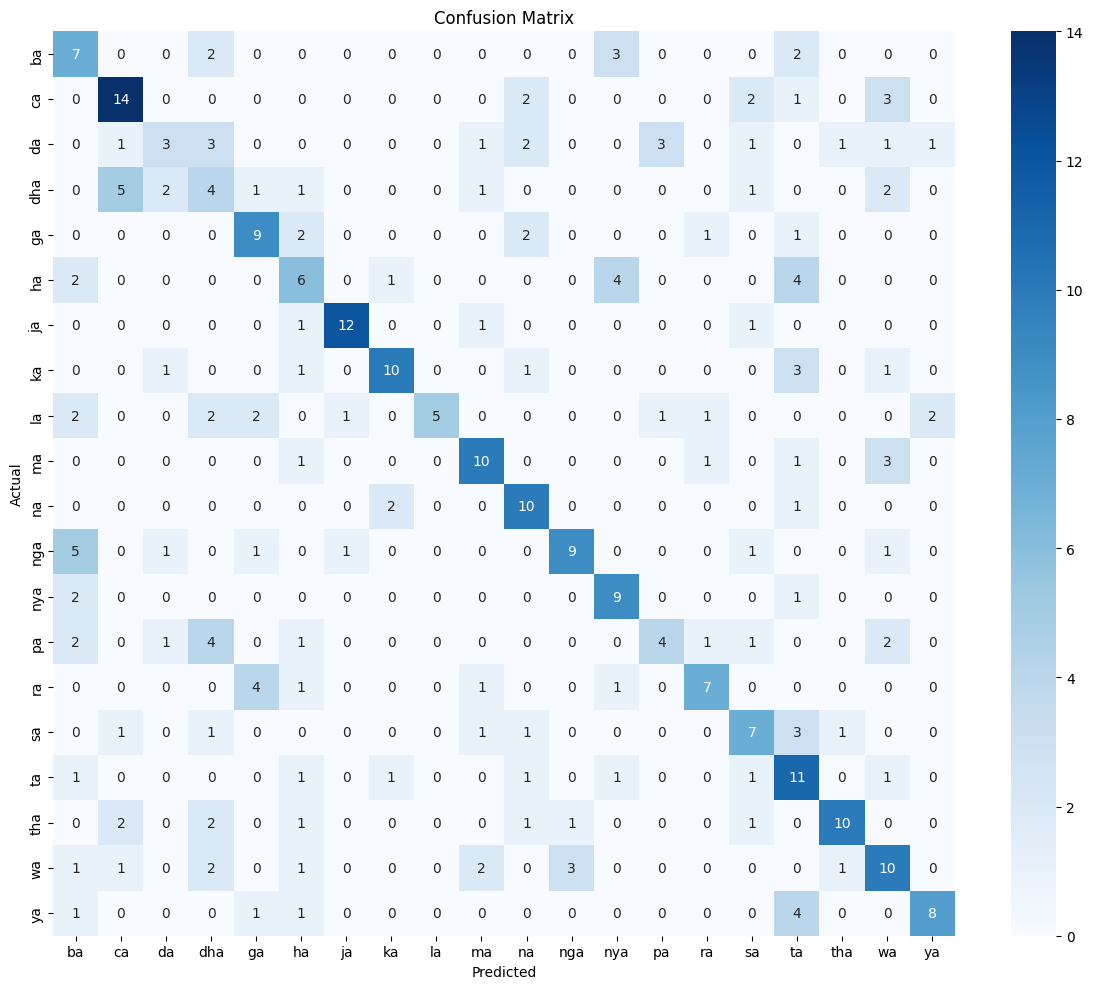

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Misal ini dataset asli sebelum di-split
# full_dataset = datasets.ImageFolder(root='dataset_split/train', transform=transform)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Ambil class names dari dataset asli
class_names = dataset.classes

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


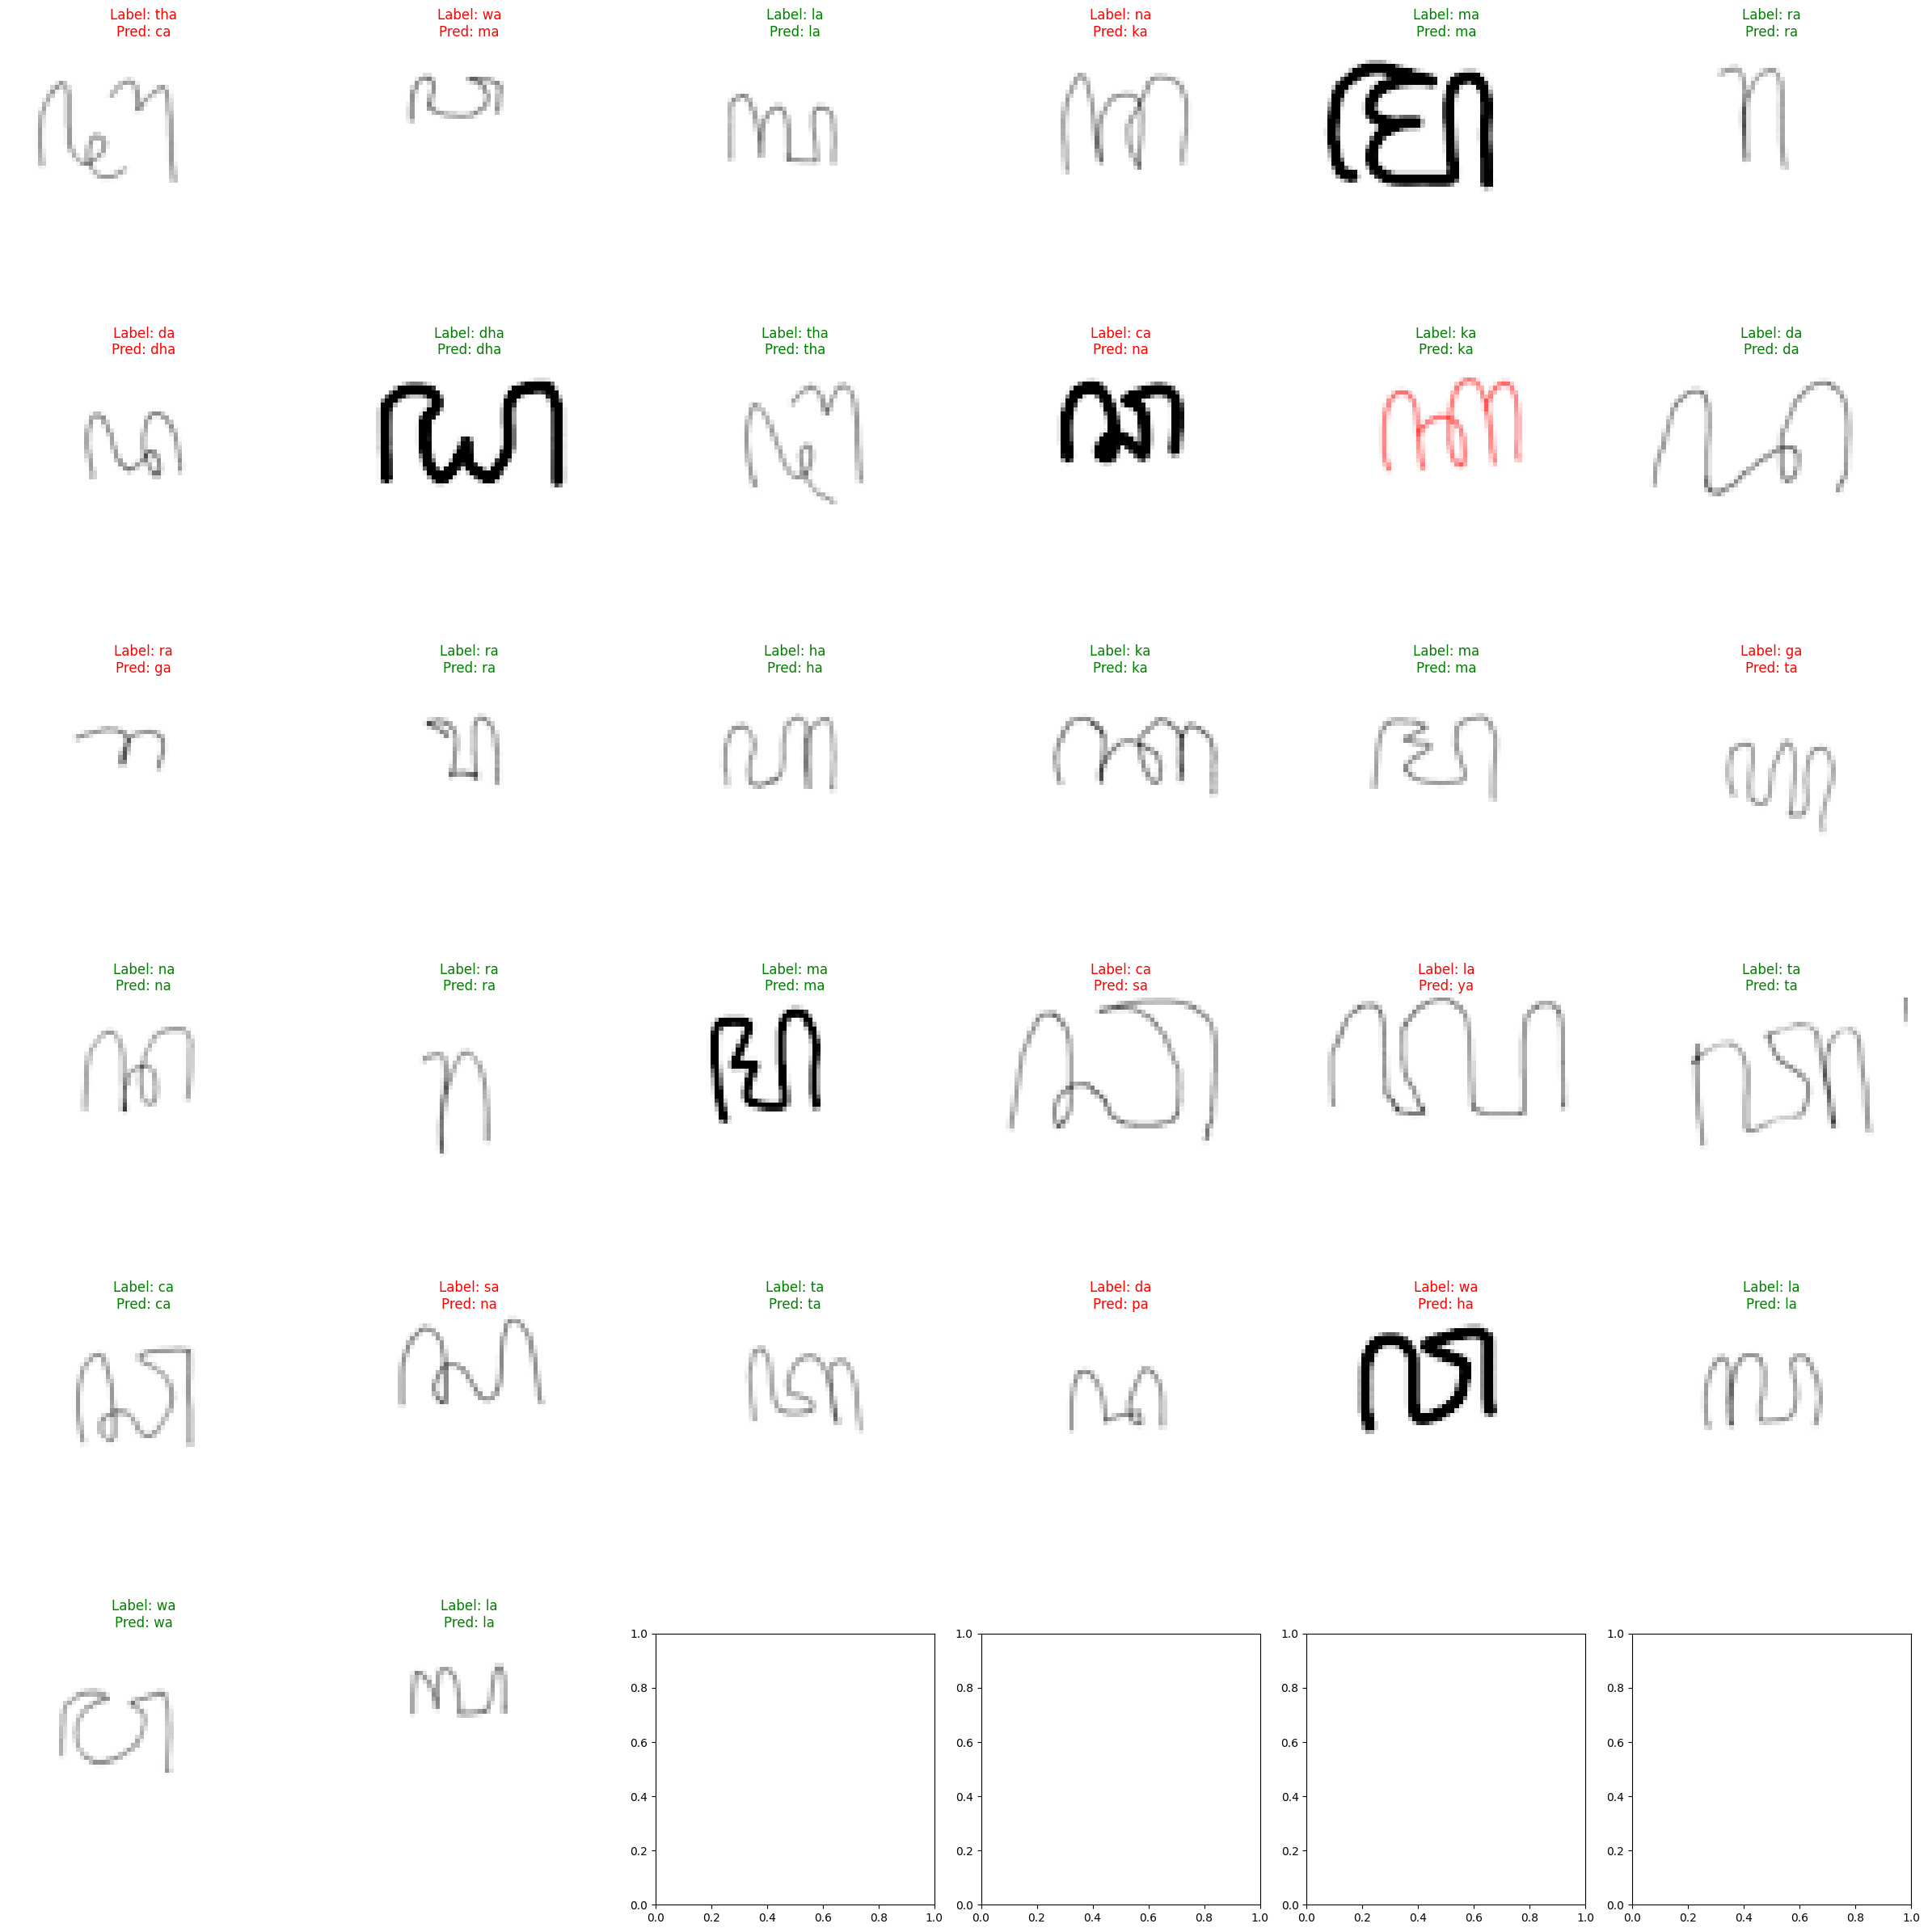

Jumlah prediksi benar: 20
Jumlah prediksi salah: 12
Rasio akurasi pada batch ini: 0.6250


In [74]:
# Buat mapping label ke kategori
label2cat = {i: c for i, c in enumerate(val_loader.dataset.dataset.classes)}  # jika val_loader adalah Subset

correct = 0
incorrect = 0

model.eval()

for features, targets in val_loader:
    features, targets = features.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(features)
        preds = outputs.argmax(dim=1)

    num_samples = min(36, features.size(0))
    indices = torch.randperm(features.size(0))[:num_samples]

    fig, axes = plt.subplots(6, 6, figsize=(24, 24))

    for img, label, pred, ax in zip(features[indices], targets[indices], preds[indices], axes.flatten()):
        img_np = img.cpu().permute(1, 2, 0).numpy()
        if img_np.shape[2] == 1:
            img_np = img_np.squeeze(2)
            ax.imshow(img_np, cmap='gray')
        else:
            ax.imshow(img_np)

        warna_font = 'g' if label == pred else 'r'
        label_name = label2cat[label.item()]
        pred_name = label2cat[pred.item()]
        ax.set_title(f"Label: {label_name}\nPred: {pred_name}", color=warna_font)
        ax.axis('off')

        if label == pred:
            correct += 1
        else:
            incorrect += 1

    plt.tight_layout()
    plt.show()

    break  # hanya 1 batch untuk visualisasi

print(f"Jumlah prediksi benar: {correct}")
print(f"Jumlah prediksi salah: {incorrect}")
print(f"Rasio akurasi pada batch ini: {correct / (correct + incorrect):.4f}")
